<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/04%20Deep%20Learning/notebooks/soluciones/02-MLP-Clasificacion-Binaria-SOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de Diabetes con MLP  

<h2>Introducción</h2>

La diabetes es una enfermedad crónica que afecta a millones de personas en el mundo, y su detección temprana es crucial para prevenir complicaciones graves. El *Diabetes Prediction Dataset* proporciona información médica y demográfica de pacientes, incluyendo variables como edad, género, índice de masa corporal (IMC), niveles de HbA1c, glucosa en sangre, historial de hipertensión, enfermedades cardíacas y hábitos de tabaquismo. Este conjunto de datos permite desarrollar modelos de aprendizaje automático para predecir el diagnóstico de diabetes (clasificación binaria: positivo/negativo), apoyando a profesionales de la salud en la identificación de pacientes en riesgo y en la personalización de tratamientos.  

Sin embargo, el dataset presenta desafíos clave:  
1. **Desbalance de clases**: Solo el **8.5%** de las muestras corresponden a casos positivos (diabetes), lo que puede sesgar el entrenamiento de modelos tradicionales.  
2. **Variables categóricas**: Género y historial de tabaquismo requieren codificación adecuada (ej.: one-hot encoding).  
3. **Tamaño del dataset**: Con **100,000 muestras**, es necesario evaluar si una arquitectura MLP puede capturar patrones complejos sin sobreajuste.  

<h2>Objetivos</h2>

1. **Diseñar arquitecturas MLP** eficientes para clasificación binaria, explorando diferentes arquitecturas (capas ocultas, neuronas, funciones de activación).  
2. **Manejar el desbalance de clases** mediante:
   - Reponderación con `class_weight` en Keras (ej.: `{0: 1.0, 1: 12.0}`).  
   - Evaluación con métricas robustas (**Recall, F1-Score, AUC-ROC**) en lugar de *accuracy*.
3. **Preprocesar variables categóricas** y numéricas para garantizar su compatibilidad con la MLP.
4. **Validar la escalabilidad** de la MLP con datasets de tamaño medio (100k muestras), monitoreando tiempos de entrenamiento y uso de recursos.

Este proyecto busca demostrar cómo una red neuronal básica (MLP) puede ser competitiva en problemas médicos reales, incluso con datos desbalanceados y heterogéneos, proporcionando un *baseline* para comparaciones con modelos más complejos (ej.: XGBoost, Redes Convolucionales).  

https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

Re-instalamos keras para evitar el warning de la importación

In [ ]:
!pip install -qq keras

Descargamos directamente de kaggle el dataset

In [1]:
import pandas as pd
import os
#--------- Este código lo copiamos desde Kaggle -----------
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iammustafatz/diabetes-prediction-dataset")

print("Path to dataset files:", path)
#-----------------------------------------------------------

path = os.path.join(path, 'diabetes_prediction_dataset.csv') # Unimos la ruta de descarga con el nombre de archivo
df = pd.read_csv(path) # Leemos el dataset
df

100%|██████████| 734k/734k [00:00<00:00, 20.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/iammustafatz/diabetes-prediction-dataset/versions/1


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


🟢 Veamos que no hay datos faltantes

In [ ]:
print(df['gender'].unique())
print(df['smoking_history'].unique())

['Female' 'Male' 'Other']
['never' 'No Info' 'current' 'former' 'ever' 'not current']


In [ ]:
df.isna().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


🔴 Haz codificación *one-hot* para las variables categóricas. No olvides usar `dtype=int` y `drop_first=True`.

In [2]:
df = pd.get_dummies(df, drop_first=True, dtype=int)
df

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,0,0,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,1,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,27.32,6.2,90,0,0,0,0,0,0,0,0
99996,2.0,0,0,17.37,6.5,100,0,0,0,0,0,0,0,0
99997,66.0,0,0,27.83,5.7,155,0,1,0,0,0,1,0,0
99998,24.0,0,0,35.42,4.0,100,0,0,0,0,0,0,1,0


🟢 Dividamos el conjunto de entrenamiento en *train/validation/test*

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop('diabetes', axis=1).values
y = df['diabetes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.15,
                                                    stratify = y,
                                                    random_state=423)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2,
                                                  stratify = y_train,
                                                  random_state=423)

print(X_train.shape, X_val.shape, X_test.shape)

(68000, 13) (17000, 13) (15000, 13)


🟢 Visualizar el balance de clases

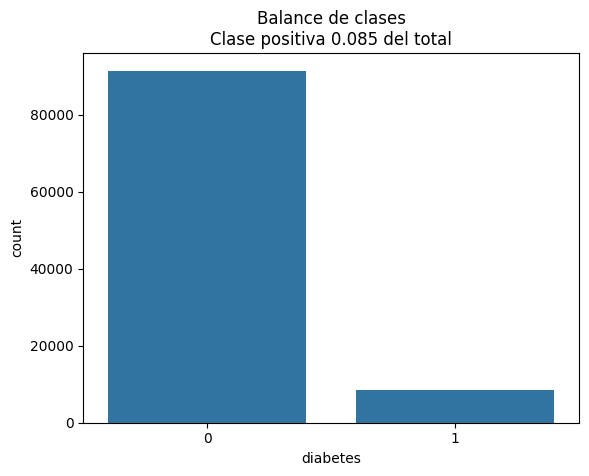

In [4]:
from seaborn import countplot
import matplotlib.pyplot as plt

ratio = y[y == 1].shape[0] / y.shape[0]

plt.figure()
plt.title(f'Balance de clases\nClase positiva {ratio} del total')
countplot(data=df,x='diabetes')
plt.show()

🟢 Probemos esta estrategia para el desbalanceo de clases. Consiste en calcular pesos para las clases, de acuerdo al desbalanceo. Posteriormente se usan esos pesos para ponderar las métricas durante el entrenamiento.

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: np.float64(0.546448087431694), 1: np.float64(5.882352941176471)}

🔴 Haz re-escalamiento `MinMaxScaler`. No olvides evitar el *data leakage*

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

🔴 Define una red neuronal con la clase `Sequential` de Keras para este problema

* Define la capa de entrada adaptada al número de features
* Define el número de capas ocultas y la cantidad de neuronas en cada una de ellas, usa la activación `relu`.
* Define la capa de salida adecuada para la clasificación binaria.
* Compila el modelo con la métrica Recall (por el desbalaceo de clases), define el compilador y la función de perdida adecuada para la clasificación binaria.

<br>

----
<br>

Una guía general sobre funciones de perdida y métricas

<br>

| Aplicación                     | Función de Pérdida (Loss)          | Métrica usual           | Última capa (output layer)          |
|---------------------------------|------------------------------------|-------------------------|-------------------------------------|
| Clasificación binaria          | `binary_crossentropy`              | `accuracy`              | `Dense(1, activation='sigmoid')`    |
| Clasificación multiclase       | `categorical_crossentropy`         | `accuracy`              | `Dense(num_clases, activation='softmax')` |
| Regresión (un valor)           | `mean_squared_error` (MSE)         | `mse` o `mae`           | `Dense(1, activation='linear')`     |
| Regresión (múltiples valores)  | `mean_squared_error` (MSE)         | `mse` o `mae`           | `Dense(num_valores, activation='linear')` |

<br>

---
<br>

Una guía general sobre optimizadores:

<br>

| Optimizador  | Ventajas                             | Casos de Uso Típicos         | Parámetros Clave               |
|--------------|--------------------------------------|------------------------------|--------------------------------|
| **Adam**     | Convergencia rápida, adaptable      | Default para MLPs, CNN, RNN  | `lr`  |
| **SGD**      | Mayor control, estable con momentum | Problemas convexos, fine-tuning | `lr`, `momentum`      |
| **RMSprop**  | Bueno para datos ruidosos           | RNNs, problemas inestables    | `lr`, `rho`          |

<br>

---

<br>

## Modelo MLP 1

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Input

#----- Completa --------

def build_model(opcion=1):
    if opcion == 1:
        model = Sequential()
        model.add(Input(shape=(X_train.shape[1],)))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['recall'])
        return model
    elif opcion == 2:
        model = Sequential()
        model.add(Input(shape=(X_train.shape[1],)))
        model.add(Dense(46, activation='relu'))
        model.add(Dense(21, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['recall'])
        return model
    else:
        print("Opción no valida")

#-----------------------

model = build_model(opcion=1)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 8)              │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121 (484.00 B)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 0 (0.00 B)

🔴 Entrena el modelo

* Elige, al menos 20 épocas.
* Usa el hiperparámetro `class_weight=class_weights`.
* Usa el hiperparámetro `batch_size=256` o `batch_size=32`. Observa la diferencia en tiempo de entrenamiento.
* Usa el conjunto de validación como `validation_data`.

Recuerda almancenar el registro de entrenamiento en la variable `history`.

In [12]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=256,
                    class_weight=class_weights,
                    validation_data=(X_val, y_val))

Epoch 1/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6481 - recall: 0.6477 - val_loss: 0.6275 - val_recall: 0.8865
Epoch 2/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5084 - recall: 0.8691 - val_loss: 0.4896 - val_recall: 0.8837
Epoch 3/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3992 - recall: 0.8572 - val_loss: 0.3548 - val_recall: 0.8478
Epoch 4/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3318 - recall: 0.8602 - val_loss: 0.3227 - val_recall: 0.8747
Epoch 5/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2970 - recall: 0.8758 - val_loss: 0.2730 - val_recall: 0.8581
Epoch 6/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2805 - recall: 0.8737 - val_loss: 0.2783 - val_recall: 0.8851
Epoch 7/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2730 - recall: 0.8792 - val_loss: 0.2585 - val_recall: 0.8803
Epoch 8/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2661 - recall: 0.8817 - val_loss: 0.2672 - val_recall: 0.8907
Epoch 9/

🟢 Graficamos las curvas de entrenamiento

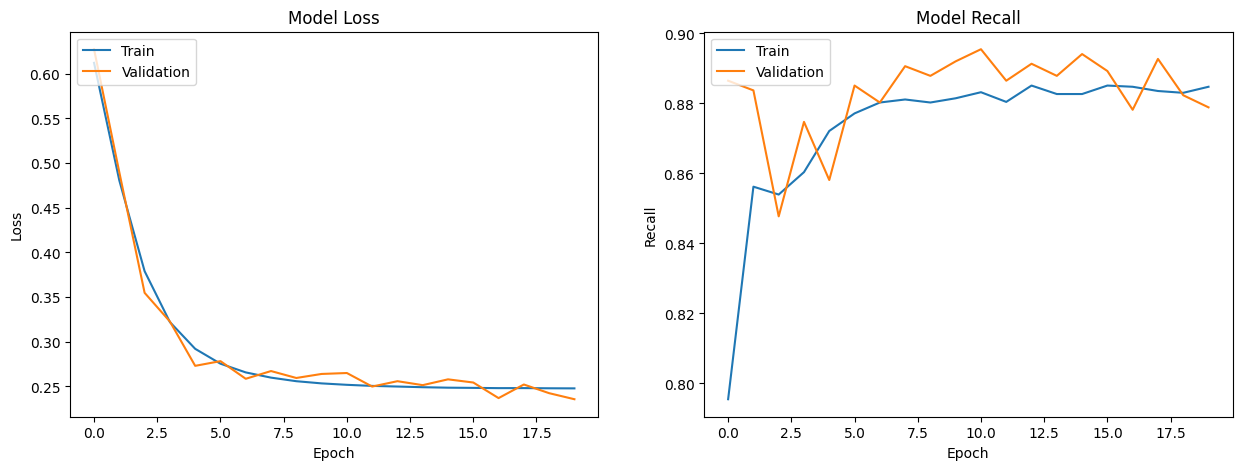

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[1].plot(history.history['recall'])
axs[1].plot(history.history['val_recall'])
axs[1].set_title('Model Recall')
axs[1].set_ylabel('Recall')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper left')
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Model Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')
fig.show()

🔴 Obten las predicciones del modelo para el conjunto de prueba. Impríme el arreglo, ¿qué interpretación tienen los valores que observas?

In [14]:
y_pred = model.predict(X_test)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


🟢 Obten las predicciones como valores de clase

In [15]:
y_pred = (y_pred > 0.5).astype(int)

🔴 Mide el rendimiento del modelo en el conjunto de prueba. Reporta las métricas:

* Accuracy
* Recall
* Precision
* F1 Score

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.8940666666666667
Recall: 0.8611764705882353
Precision: 0.43745019920318723
F1 Score: 0.5801849405548216


🟢 Muestra la matriz de confusión

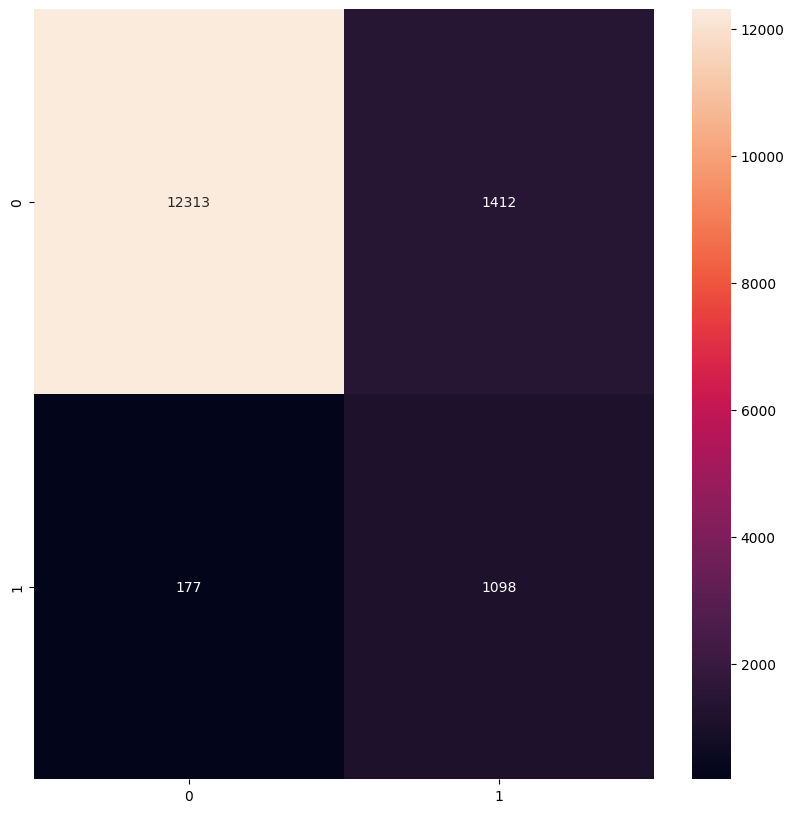

In [17]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
plt.show()

## Modelo ML clásico

🔴 **OPCIONAL** Como comparación, realiza la misma tarea de clasificación binaria entrenando un clasificador de Machine Learning clásico (de scikit-learn).

Reporta la mismas métricas y la matriz de confusión.

* ¿Cuál tuvo mejor rendimiento? **El SVM**
* ¿Cuál tardo más en entrenarse? **Tardó alrededor de 1 minuto**

Tiempo de entrenamiento: 31.522 segundos
Tiempo de predicción: 7.674 segundos
Train Accuracy: 0.9620735294117647
Test Accuracy: 0.9609333333333333
Train Recall: 0.5702422145328719
Test Recall: 0.5576470588235294
Train Precision: 0.9719846652904748
Test Precision: 0.9699863574351978
Train F1 Score: 0.7187874822811035
Test F1 Score: 0.7081673306772909


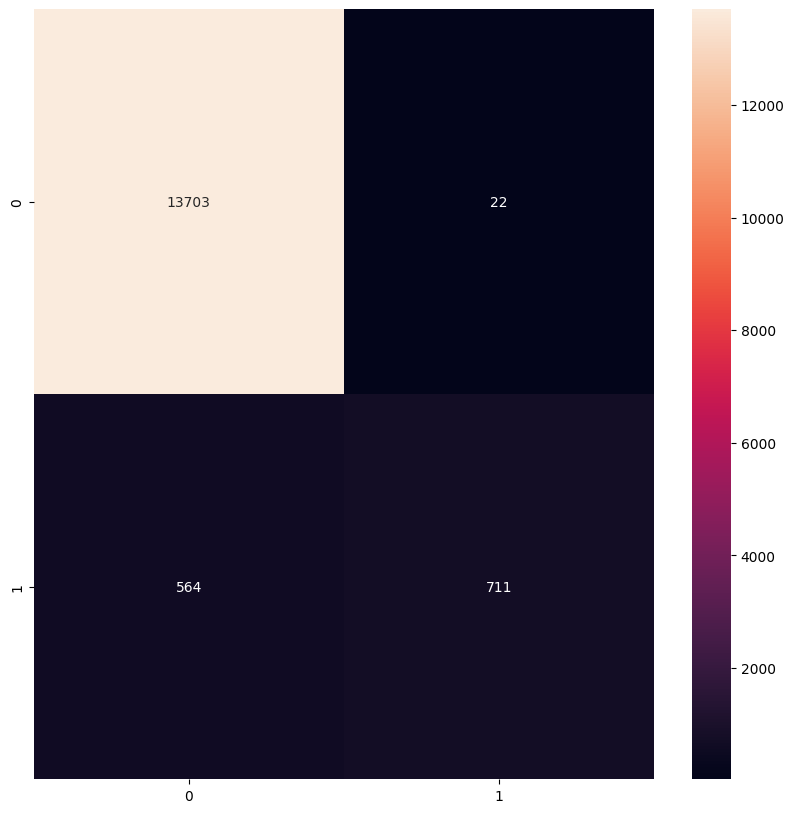

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from seaborn import heatmap
import time

clf = SVC()
inicio = time.time()
clf.fit(X_train, y_train)
print(f'Tiempo de entrenamiento: {round(time.time() - inicio,3)} segundos')
y_train_pred = clf.predict(X_train)
inicio = time.time()
y_pred = clf.predict(X_test)
print(f'Tiempo de predicción: {round(time.time() - inicio,3)} segundos')

print(f'Train Accuracy: {accuracy_score(y_train, y_train_pred)}')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Train Recall: {recall_score(y_train, y_train_pred)}')
print(f'Test Recall: {recall_score(y_test, y_pred)}')
print(f'Train Precision: {precision_score(y_train, y_train_pred)}')
print(f'Test Precision: {precision_score(y_test, y_pred)}')
print(f'Train F1 Score: {f1_score(y_train, y_train_pred)}')
print(f'Test F1 Score: {f1_score(y_test, y_pred)}')

plt.figure(figsize=(10, 10))
heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
plt.show()

🔵 En conclusión, en este caso, es mejor usar métodos de Machine Learning clásico.

* El entrenamiento en ambos métodos (SVM y MLP) fué similar.
* La inferencia fué más rápida en el caso del MLP.
* El rendimiento fué mejor en el caso del SVM.